This example showcases a sample Machine Learning pipeline for supervised learning using a Factorization Machine on a ratings data set. A Factorization Machine performs matrix factorization that can be used for recommendation or predictive modelling with sparse transactional data.                                                  
                                                                      
The steps include:                                                                                                             
1. PREPARE AND EXPLORE  
  a) Load data set into CAS  
<br>
2. PERFORM SUPERVISED LEARNING  
  a) Fit a model by using Factorization Machine for a sample of reviews data set  
<br>  
3. EVALUATE AND IMPLEMENT  
  a) Score the data using Factorization Machine model  
  b) Assess model performance                                      

### Import packages

In [1]:
from swat import *
import matplotlib.pyplot as plt
%matplotlib inline

### CAS Server connection details

In [2]:
cashost='localhost'
casport=5570
casauth='~/.authinfo'

### Start CAS session

In [3]:
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

### Import action sets

In [4]:
sess.loadactionset(actionset="factmac")
sess.loadactionset(actionset="astore")

NOTE: Added action set 'factmac'.
NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.000372s, mem: 0.0291mb

### Load data into CAS  

In [5]:
# Load train data
indata_dir="/home/viyauser/casuser/data"
#indata_dir = "data"
if not sess.table.tableExists(table="reviews500").exists:
    sess.upload_file(indata_dir+"/reviews500.sas7bdat", casout={"name":"reviews500"})

# Load score data
if not sess.table.tableExists(table="reviews_user99").exists:
    sess.upload_file(indata_dir+"/reviews_user99.sas7bdat", casout={"name":"reviews_user99"})

NOTE: Cloud Analytic Services made the uploaded file available as table REVIEWS500 in caslib CASUSER(viyauser).
NOTE: The table REVIEWS500 has been created in caslib CASUSER(viyauser) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table REVIEWS_USER99 in caslib CASUSER(viyauser).
NOTE: The table REVIEWS_USER99 has been created in caslib CASUSER(viyauser) from binary data uploaded to Cloud Analytic Services.


### Modeling:                                                            
The Factorization Machine will run with the following settings:  
  -The optimization will stops after 20 iterations  
  -The model will have 5 factors  
  -The optimization learning step is 0.15                             

In [6]:
sess.factmac.factmac(
  table={"name":"reviews500"},
  inputs={"user", "item"},
  nominals={"user", "item"},
  target="rating",
  seed=12345,
  maxIter=20,
  nFactors=5,
  learnStep=0.15,
  id={"user", "item", "rating"},
  savestate={"name":"fm_astore_model", "replace":True}
)


NOTE: Using SEED=12345.
NOTE: Beginning data reading and levelization...
NOTE: Data reading and levelization complete.
NOTE: Beginning optimization of the factorization machine model...
NOTE: >>> Progress: completed iteration 1
NOTE: >>> Progress: completed iteration 2
NOTE: >>> Progress: completed iteration 3
NOTE: >>> Progress: completed iteration 4
NOTE: >>> Progress: completed iteration 5
NOTE: >>> Progress: completed iteration 6
NOTE: >>> Progress: completed iteration 7
NOTE: >>> Progress: completed iteration 8
NOTE: >>> Progress: completed iteration 9
NOTE: >>> Progress: completed iteration 10
NOTE: >>> Progress: completed iteration 11
NOTE: >>> Progress: completed iteration 12
NOTE: >>> Progress: completed iteration 13
NOTE: >>> Progress: completed iteration 14
NOTE: >>> Progress: completed iteration 15
NOTE: >>> Progress: completed iteration 16
NOTE: >>> Progress: completed iteration 17
NOTE: >>> Progress: completed iteration 18
NOTE: >>> Progress: completed iteration 19
NOTE: 

[ModelInfo]

 Model Information
 
           Description     Value
 0  Maximum Iterations     20.00
 1   Number of Factors      5.00
 2       Learning Step      0.15
 3                Seed  12345.00

[NObs]

 Number of Observations
 
                           Type         N
 0  Number of Observations Read  500034.0
 1  Number of Observations Used  500034.0

[DescStatsInt]

 Interval Variables
 
   Variable      Mean    StdDev
 0   rating  3.501254  1.323776

[DescStatsNom]

 Nominal Variables
 
   Variable  NumLevels
 0     user      500.0
 1     item    10000.0

[OptIterHistory]

     Progress  Objective      Loss
 0        1.0   0.797921  0.797921
 1        2.0   0.493202  0.493202
 2        3.0   0.448072  0.448072
 3        4.0   0.428111  0.428111
 4        5.0   0.414230  0.414230
 5        6.0   0.412651  0.412651
 6        7.0   0.404533  0.404533
 7        8.0   0.403440  0.403440
 8        9.0   0.399384  0.399384
 9       10.0   0.401033  0.401033
 10      11.0   0.398914  0.398914
 11      12.0   0.397253  0.397253
 12      13.0   0.396511  0.396511
 13      14.0   0.396151  0.396151
 14      15.0   0.396155  0.396155
 15      16.0   0.397337  0.397337
 16      17.0   0.396197  0.396197
 17      18.0   0.396573  0.396573
 18      19.0   0.398982  0.398982
 19      20.0   0.396457  0.396457

[FinalLoss]

 Final Exact Loss
 
   Criterion     Value
 0       MSE  0.405528
 1      RMSE  0.636811

+ Elapsed: 4.24s, user: 22.9s, sys: 0.022s, mem: 20.1mb

### Score using ASTORE

In [7]:
# Scoring the reviews dataset for user 99 based on the model developed 
sess.astore.score(
  table={"name":"reviews_user99"},
  rstore={"name":"fm_astore_model"},
  out={"name":"reviews_user99_scored", "replace":True}
)

,Task,Seconds,Percent
0,Loading the Store,0.000013,0.000056
1,Creating the State,0.027757,0.121254
2,Scoring,0.201146,0.878685
3,Total,0.228917,1.000000


### Plot predicted values

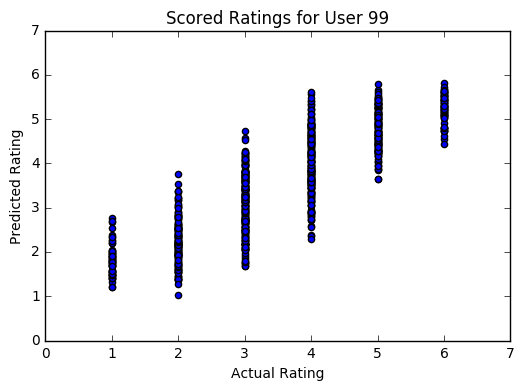

In [8]:
# Plot the predicted vs actual ratings for the scored dataset
plot_tbl=sess.CASTable("reviews_user99_scored")
plot_tbl.where="rating>0.0"

allRows=20000  # Assuming max rows in reviews_user99_scored table is <= 20,000
plot_df=plot_tbl.fetch(to=allRows)['Fetch']
plt.scatter(plot_df["rating"], plot_df["P_rating"])
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("Scored Ratings for User 99")
plt.show()

### End CAS session

In [9]:
sess.close()